<a href="https://colab.research.google.com/github/ChadCYB/Blackjack-Analysis-and-Multi-Model-Solutions/blob/main/Blackjack_gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 1. Import Dependencies

In [ ]:
import gym
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, accuracy_score, precision_recall_fscore_support


2. Mount Google Drive

In [ ]:
# Mount Google Drive for data access
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Data Loading and Preprocessing

In [ ]:
def load_data(filepath):
    data = pd.read_csv(filepath, sep=',', nrows=100000)
    data['initial_hand'] = data['initial_hand'].apply(eval)
    data['dealer_final'] = data['dealer_final'].apply(eval)
    data['player_final'] = data['player_final'].apply(eval)
    data['actions_taken'] = data['actions_taken'].apply(eval)

    # Explode the player_final and actions_taken columns correctly
    data = data.explode('player_final')
    # Flatten actions_taken further
    data['actions_taken'] = data['actions_taken'].apply(lambda x: [action for sublist in x for action in (sublist if isinstance(sublist, list) else [sublist])])
    data = data.explode('actions_taken')

    # Compute player_total, dealer_card, and player_ace
    data['player_total'] = data['player_final'].apply(lambda hand: sum(hand) if isinstance(hand, list) else hand)
    data['dealer_card'] = data['dealer_final'].apply(lambda x: x[0] if isinstance(x, list) else x)
    data['player_ace'] = data['player_final'].apply(lambda hand: 1 if 11 in hand else 0)

    # Filter rows where actions_taken is 'H' or 'S'
    data = data[data['actions_taken'].isin(['H', 'S'])]
    data['action_binary'] = data['actions_taken'].apply(lambda x: 1 if x == 'S' else 0)

    print("Data shape after processing:", data.shape)
    if data.empty:
        raise ValueError("No data left after processing. Check filtering criteria.")

    return data


4. Model Training

In [ ]:
def train_model(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model


5. Action Prediction and Visualization

In [ ]:
def predict_action(dealer_card, player_total, player_has_ace, model):
    input_features = pd.DataFrame({
        'dealer_card': [dealer_card],
        'player_total': [player_total],
        'player_ace': [1 if player_has_ace else 0]
    })
    action_prob = model.predict_proba(input_features)[0]
    actions = ['Hit', 'Stand']
    action = actions[np.argmax(action_prob)]
    print(f"\nRecommended action: {action}")
    print(f"\nProbability of 'Hit': {action_prob[0]:.2f}")
    print(f"\nProbability of 'Stand': {action_prob[1]:.2f}\n")
    plt.figure(figsize=(8, 4))
    sns.barplot(x=actions, y=action_prob, color='mediumturquoise')
    plt.title('Action Probabilities')
    plt.ylabel('Probability')
    plt.show()
    plt.figure(figsize=(6, 6))
    plt.pie(action_prob, labels=actions, autopct='%1.1f%%', startangle=90, colors=['tomato', 'mediumseagreen'])
    plt.title('Action Distribution')
    plt.show()


6. Display Confusion Matrix & accuracy



In [ ]:
def display_confusion_matrix_and_metrics(model, X_test, y_test):
    # Predict labels based on test set
    y_pred = model.predict(X_test)

    # Generate confusion matrix and calculate accuracy
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    # Display the confusion matrix using heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hit', 'Stand'], yticklabels=['Hit', 'Stand'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Create DataFrame for metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [accuracy, precision, recall, f1]
    })

    # Display metrics heatmap
    plt.figure(figsize=(8, 3))
    sns.heatmap(metrics_df.set_index('Metric'), annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
    plt.title('Performance Metrics Heatmap')
    plt.show()

    # Print metrics table
    print("Model Performance Metrics:")
    print(metrics_df.to_string(index=False))

    return metrics_df


7. Simulation Functions

In [ ]:
def run_simulation_dynamic_display(model, n_episodes=10000):
    env = gym.make("Blackjack-v1", sab=True, new_step_api=True)
    win, lose, even = 0, 0, 0
    results = pd.DataFrame(columns=['Episode', 'Win', 'Lose', 'Even'])

    plt.ion()
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    for episode in tqdm(range(n_episodes), desc="Simulating Games"):
        obs = env.reset()
        done = False

        while not done:
            dealer_card, player_total, player_ace = obs
            input_features = pd.DataFrame({
                'dealer_card': [dealer_card],
                'player_total': [player_total],
                'player_ace': [int(player_ace)]  # Ensuring integer
            })
            action = model.predict(input_features)[0]
            next_obs, reward, done, truncated, _ = env.step(action)
            done = done or truncated

            if done:
                if reward > 0:
                    win += 1
                elif reward < 0:
                    lose += 1
                else:
                    even += 1

        # Update results and replot every 10 episodes
        if episode % 10 == 0 or episode == n_episodes - 1:
            new_row = {'Episode': episode + 1, 'Win': win, 'Lose': lose, 'Even': even}
            results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

            total_games = win + lose + even
            win_pct = (win / total_games) * 100 if total_games > 0 else 0
            lose_pct = (lose / total_games) * 100 if total_games > 0 else 0
            draw_pct = (even / total_games) * 100 if total_games > 0 else 0

            ax1.clear()
            results.plot(x='Episode', y=['Win', 'Lose', 'Even'], kind='line', ax=ax1)
            ax1.set_title('Cumulative Wins, Losses, and Draws')
            ax1.grid(True)

            ax2.clear()
            bars = ax2.bar(['Wins %', 'Losses %', 'Draws %'], [win_pct, lose_pct, draw_pct], color=['green', 'red', 'blue'])
            ax2.set_ylim(0, 100)
            ax2.set_title('Percentage Results after ' + str(episode + 1) + ' Games')
            for bar in bars:
                yval = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')

            ax3.clear()
            ax3.axis('off')
            ax3.text(0.5, 0.5, f"Win: {win} ({win_pct:.2f}%)\nLose: {lose} ({lose_pct:.2f}%)\nEven: {even} ({draw_pct:.2f}%)",
                     horizontalalignment='center', verticalalignment='center', fontsize=12, transform=ax3.transAxes)

            clear_output(wait=True)  # Clear previous output
            display(fig)  # Display the figure object

    plt.ioff()
    plt.close(fig)  # Close the figure to avoid duplicate display

    print(f"Final Results:")
    print(f"Win: {win} ({win / total_games * 100:.2f}%)")
    print(f"Lose: {lose} ({lose / total_games * 100:.2f}%)")
    print(f"Even: {even} ({even / total_games * 100:.2f}%)")

8. Execution Block

Data shape after processing: (123276, 16)


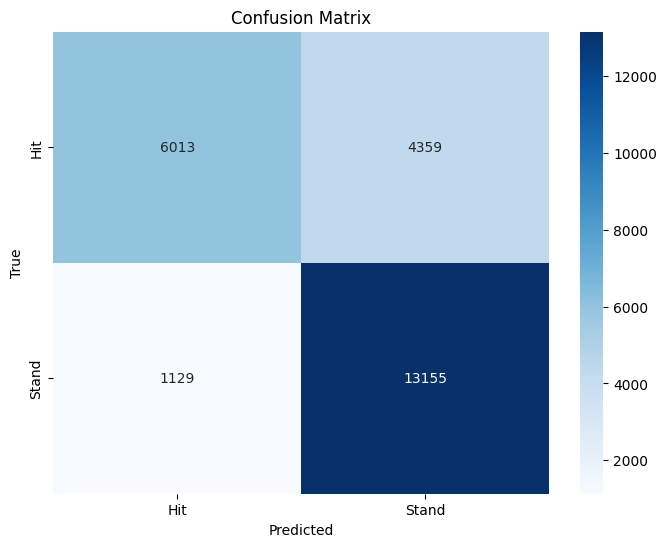

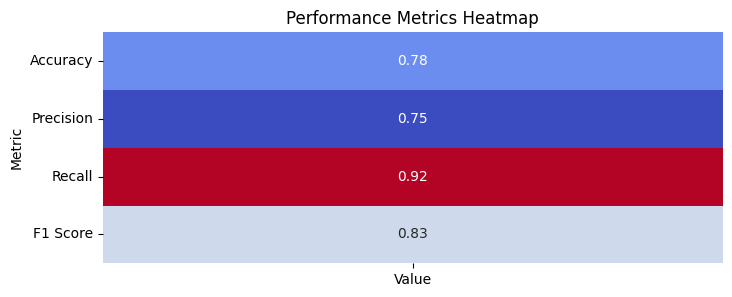

Model Performance Metrics:
   Metric    Value
 Accuracy 0.777417
Precision 0.751113
   Recall 0.920961
 F1 Score 0.827411

Recommended action: Stand

Probability of 'Hit': 0.32

Probability of 'Stand': 0.68



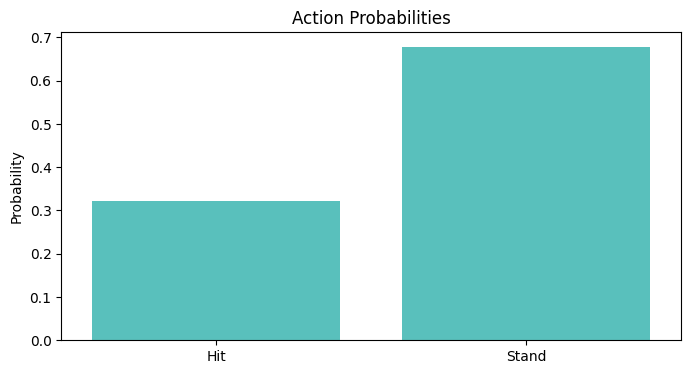

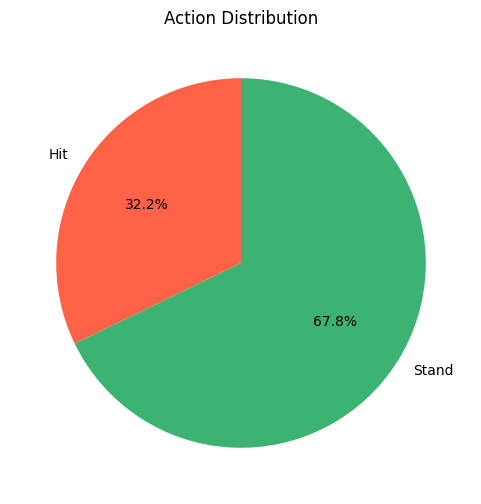


Recommended action: Stand

Probability of 'Hit': 0.20

Probability of 'Stand': 0.80



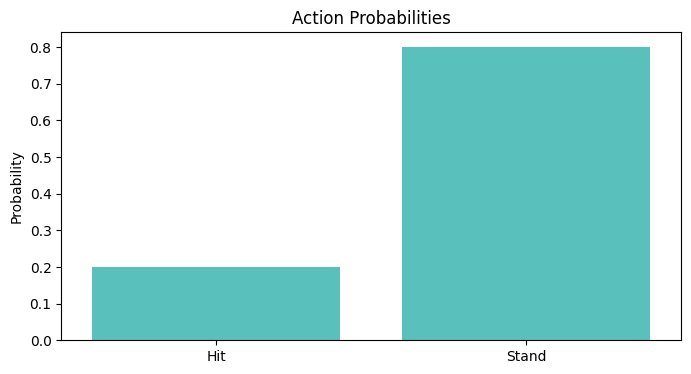

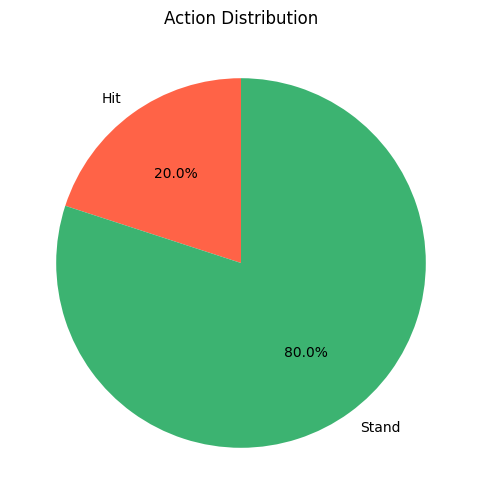

In [ ]:
# Load data and prepare for modeling
file_path = '/content/drive/My Drive/blackjack_simulator.csv'
data = load_data(file_path)
features = data[['dealer_card', 'player_total', 'player_ace']]
target = data['action_binary']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model = train_model(X_train, y_train)

# Display the confusion matrix and accuracy using the test data
display_confusion_matrix_and_metrics(model, X_test, y_test)

# Train the model and run predictions
model = train_model(features, target)
predict_action(10, 15, False, model)
predict_action(6, 12, True, model)

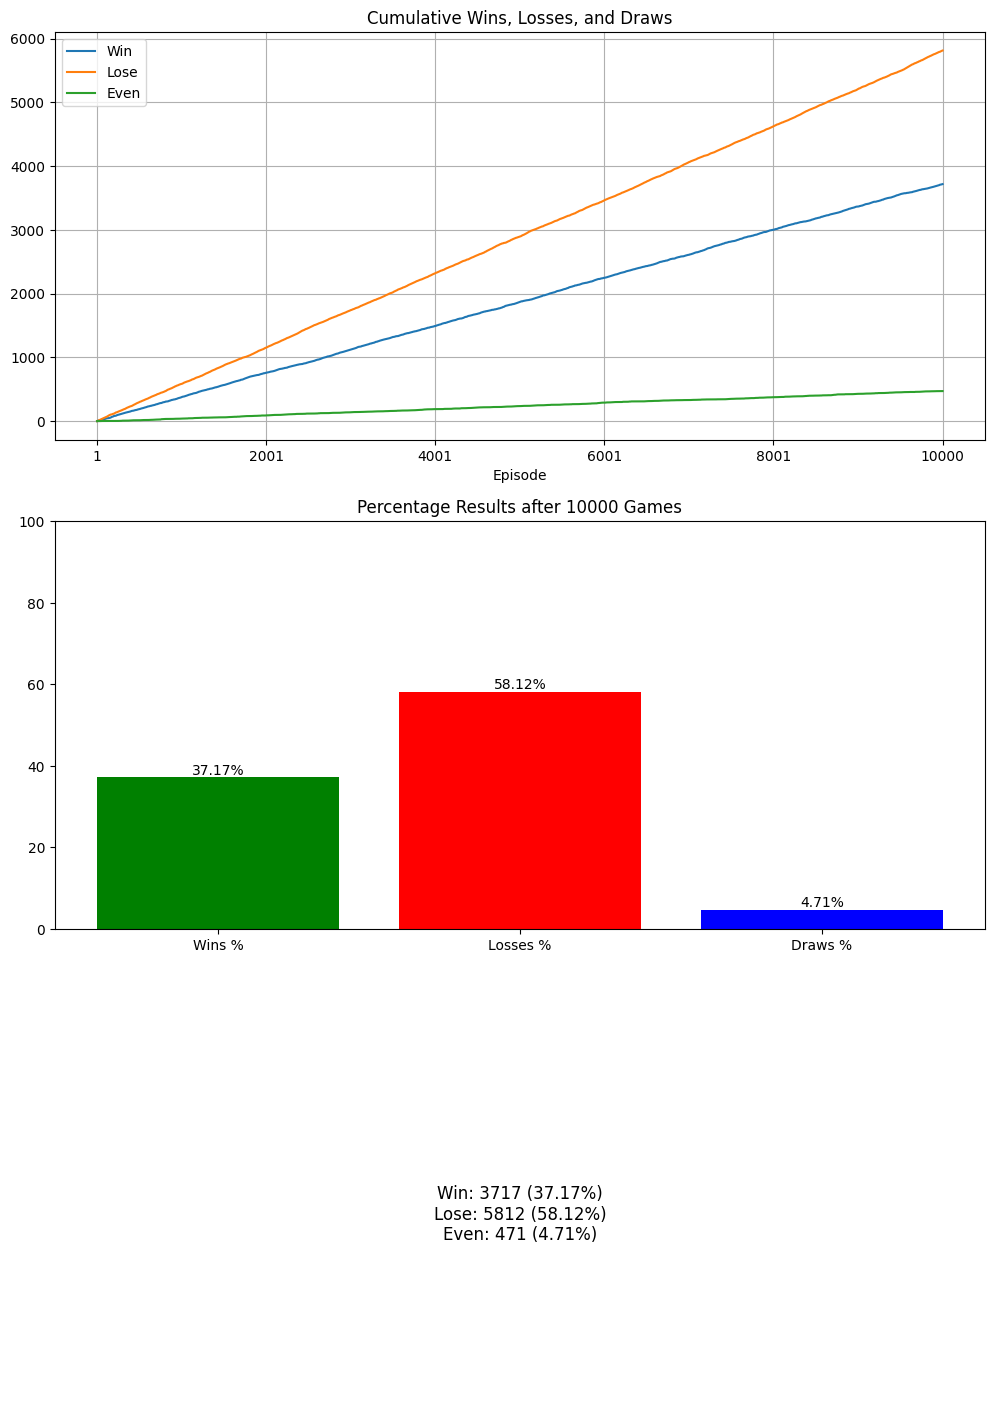

Final Results:
Win: 3717 (37.17%)
Lose: 5812 (58.12%)
Even: 471 (4.71%)


In [ ]:
# Run the Blackjack simulation

run_simulation_dynamic_display(model, 10000)


In [ ]:
import gym
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def run_simulation_dynamic_display(model, n_episodes=10000):
    env = gym.make("Blackjack-v1", sab=True)
    try:
        # Attempt to use the new step API if available
        env = gym.wrappers.RecordEpisodeStatistics(env, new_step_api=True)
    except TypeError:
        # Fall back to the old API if the new API flag isn't accepted
        env = gym.wrappers.RecordEpisodeStatistics(env)

    win, lose, even = 0, 0, 0
    results = pd.DataFrame(columns=['Win', 'Lose', 'Even'])

    for episode in tqdm(range(n_episodes), desc="Simulating Games"):
        obs = env.reset()
        done = False

        while not done:
            dealer_card, player_total, player_ace = obs
            player_ace = int(player_ace)  # Ensure it's treated as an integer

            # Prepare input for prediction
            input_features = pd.DataFrame({
                'dealer_card': [dealer_card],
                'player_total': [player_total],
                'player_ace': [player_ace]
            })
            action = model.predict(input_features)[0]

            # Step through the environment and handle different output formats
            step_output = env.step(action)
            if len(step_output) == 5:  # New API format
                next_obs, reward, terminated, truncated, info = step_output
                done = terminated or truncated
            else:  # Old API format
                next_obs, reward, done, info = step_output

            if done:
                if reward > 0:
                    win += 1
                elif reward < 0:
                    lose += 1
                else:
                    even += 1

        # Update results for every 1000 episodes
        if episode % 1000 == 0 or episode == n_episodes - 1:
            new_results = pd.DataFrame({'Win': [win], 'Lose': [lose], 'Even': [even]})
            results = pd.concat([results, new_results], ignore_index=True)
            clear_output(wait=True)
            display(results.style.set_caption("Live Simulation Results"))

    total_game = win + lose + even
    print(f"\nFinal Results:")
    print(f"Win: {win}\t({win/total_game*100:.2f}%)")
    print(f"Lose: {lose}\t({lose/total_game*100:.2f}%)")
    print(f"Even: {even}\t({even/total_game*100:.2f}%)")

# Run the simulation
run_simulation_dynamic_display(model, 10000)


,Win,Lose,Even
0,0,1,0
1,382,562,57
2,743,1141,117
3,1122,1720,159
4,1491,2311,199
5,1846,2909,246
6,2232,3471,298
7,2589,4062,350
8,2962,4647,392
9,3357,5215,429



Final Results:
Win: 3748	(37.48%)
Lose: 5783	(57.83%)
Even: 469	(4.69%)
